In [2]:
# IMPORTS
import pandas as pd 
import wandb 
import numpy as np
import matplotlib.pyplot as plt 
import os, sys
import wandb 
import time
import json
import matplotlib as mpl
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
R_TEAM = [0.5, 0.75, 1.0, 1.25, 1.5]
NPREY = [2,5,10]

In [9]:
# GLOBALS + wandb init
ENTITY = 'tpn'
PROJECT = 'project_final'

api = wandb.Api()
num_runs = len(api.runs(path=f'{ENTITY}/{PROJECT}'))
finished_runs = api.runs(
    path=f'{ENTITY}/{PROJECT}', 
    filters={"state": "finished"})
print(f"""
    Entity: {ENTITY}
    Project: {PROJECT}
    Number of runs: {num_runs}
    Finished runs: {len(finished_runs)}
    """)
runs_summary = pd.DataFrame()
for run in finished_runs:
    config = run.config
    summary = run.summary
    if run.state != 'finished':
        print(f'Run {run.name} is not finished')
        continue
    time.sleep(0.01)
    metrics = pd.DataFrame([dict(summary)])
    metrics['algorithm_type'] = config['algorithm_type']
    metrics['run_id'] = run.name
    metrics['env_config'] = json.dumps(config['env_config'])
    # metrics['nprey'] = config['env_config']['nprey']
    # metrics['reward_lone'] = config['env_config']['reward_lone']
    # metrics['reward_team'] = config['env_config']['reward_team']
    metrics['config'] = json.dumps(config)
    if len(runs_summary) == 0:
        runs_summary = metrics
    else:
        runs_summary = pd.concat([runs_summary, metrics])

# for a given set of nrpey and rteam, plot training curves
# get new runs for the set of parameters 
def get_performance_df(nprey, rteam, algo):
    collated_performances_df = None
    struct_df = pd.DataFrame(
            [],
            index = np.arange(0, 50001, 500),
            columns = ['episode_reward', 'episode_length', 'episode_assists', 'episodes_total']
        ).fillna(0)
    subset = api.runs(
        path=f'{ENTITY}/{PROJECT}', 
        filters={
            "state": "finished",
            "config.algorithm_type": algo,
            "config.env_config.nprey": nprey,
            "config.env_config.reward_team": rteam
            })
    print(f"""
            For nprey={nprey}, rteam={rteam}, algo={algo}:
            {len(subset)} runs
            """)
    if len(subset) == 0:
        return None 
    # get the training curves for the all runs in the subset 
    for run in subset:
        run_name = run.name
        performance_df = struct_df.copy()
        history = pd.DataFrame(run._full_history())
        df1 = history.loc[:, ['episode_reward_mean', 'episode_len_mean', 'episode_assists_mean', 'episodes_total']].dropna()
        df1.columns = ['episode_reward', 'episode_length', 'episode_assists', 'episodes_total']
        for col in df1.columns:
            if col == 'epsides_total':
                continue
            performance_df[col] = np.interp(struct_df.index, df1['episodes_total'], df1[col])

        collated_performances_df = np.dstack([np.array(struct_df), np.array(performance_df)])\
        if collated_performances_df is None else\
            np.dstack([collated_performances_df, np.array(performance_df)])
    collated_performances_df = collated_performances_df[:, :, 1:]
    collated_performances_df = pd.DataFrame(
        collated_performances_df.mean(-1),
        index = struct_df.index,
        columns = struct_df.columns)
    collated_performances_df = collated_performances_df.rolling(5, axis=0).mean().dropna()
    return collated_performances_df


    Entity: tpn
    Project: project_final
    Number of runs: 380
    Finished runs: 300
    


Performances of ['independent', 'shared'] alogirthms, for different r_team [0.5, 0.75, 1.0, 1.25, 1.5] and different n_prey [2, 5, 10]. Map Size and Pred Vision for {PROJECT} are set to 20 and 3 respectively. 

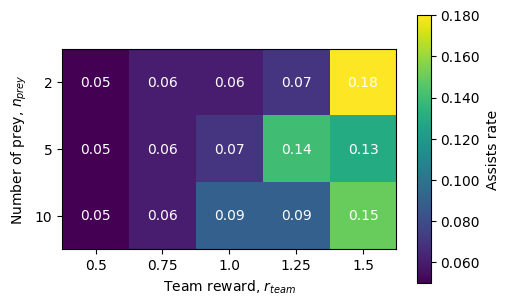

In [13]:
data = runs_summary.copy()
data['nprey'] = data['env_config'].apply(lambda x: json.loads(x)['nprey'])
# REAPLCE WITH eval_assists / eval_kills
data['team_assists_rate'] = data.apply(lambda x: x['eval_assists']/x['nprey'], axis=1)
# data['hits_rate'] = data['hits_mean']
# data['reward_team'] = 1.0
# REPLACE WITH REAL ENV CONFIG 
data['reward_team'] = data['env_config'].apply(lambda x: json.loads(x)['reward_team'])
# data['pred_stun_rate'] = data['env_config'].apply(lambda x: json.loads(x)['pred_stun_rate'])
ycols_nprey = NPREY
xcols_rteam = R_TEAM

assists_mean = np.zeros((len(ycols_nprey), len(xcols_rteam)))
for i, nprey in enumerate(ycols_nprey):
    for j, rteam in enumerate(xcols_rteam):
        team_assists_rate = data[
            (data['nprey'] == nprey) & 
            (data['reward_team'] == rteam) &
            # (data['pred_stun_rate'] == 20) &
            (data['algorithm_type'] == 'independent')]['team_assists_rate'].mean()
        if team_assists_rate is None or pd.isna(team_assists_rate):
            team_assists_rate = 0 + abs(np.random.normal(0, 0.1))
        assists_mean[i, j] = round(team_assists_rate, 2)
        # assists_mean[i, j] = team_assists_rate
        
fig, ax = plt.subplots(figsize=(5, 7))
im = ax.imshow(assists_mean)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(xcols_rteam)), labels=xcols_rteam)
ax.set_yticks(np.arange(len(ycols_nprey)), labels=ycols_nprey)
ax.set_ylabel('Number of prey, $n_{prey}$')
ax.set_xlabel('Team reward, $r_{team}$')

# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(ycols_nprey)):
    for j in range(len(xcols_rteam)):
        text = ax.text(j, i, assists_mean[i, j],
                       ha="center", va="center", color="w")

# ax.set_title("Rate of assists.")
fig.tight_layout()
clb = fig.colorbar(im, ax=ax, shrink=0.4, format="%.3f")
clb.set_label('Assists rate')
plt.show()
fig.savefig('assists_rate.png', dpi=300)



            For nprey=5, rteam=1.25, algo=shared:
            10 runs
            


/tmp/ipykernel_99480/2034990726.py:80: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  collated_performances_df = collated_performances_df.rolling(5, axis=0).mean().dropna()



            For nprey=5, rteam=0.75, algo=shared:
            10 runs
            


/tmp/ipykernel_99480/2034990726.py:80: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  collated_performances_df = collated_performances_df.rolling(5, axis=0).mean().dropna()



            For nprey=5, rteam=1.25, algo=independent:
            10 runs
            


/tmp/ipykernel_99480/2034990726.py:80: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  collated_performances_df = collated_performances_df.rolling(5, axis=0).mean().dropna()



            For nprey=5, rteam=0.75, algo=independent:
            10 runs
            


/tmp/ipykernel_99480/2034990726.py:80: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  collated_performances_df = collated_performances_df.rolling(5, axis=0).mean().dropna()


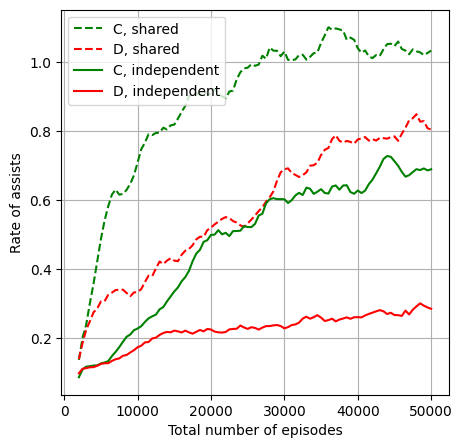

In [14]:
algorithm_types = ['shared', 'independent']
set_C  = dict(
    nprey = 5,
    rteam = 1.25,
)
set_D = dict(
    nprey = 5,
    rteam = 0.75,
)
fig, ax = plt.subplots(figsize=(5, 5))
for algo in algorithm_types:
    line_type = '--' if algo == 'shared' else '-'
    setC = get_performance_df(set_C['nprey'], set_C['rteam'], algo)
    if setC is not None:
        ax.plot(setC.index, setC['episode_assists'], line_type, color='green', label=f'C, {algo}')

    setD = get_performance_df(set_D['nprey'], set_D['rteam'], algo)
    if setD is not None:
        ax.plot(setD.index, setD['episode_assists'], line_type, color='red', label=f'D, {algo}')

ax.grid()
ax.legend()
ax.set_ylabel('Rate of assists')
ax.set_xlabel('Total number of episodes')
plt.show()
fig.savefig('relative_performance.png', dpi=300)

In [7]:
def get_analysis_df(algo, nprey, rteam):
    file_name_prefix = ""  # _chaser, _fixed, _follower
    big_analysis_df = None
    subset = api.runs(
                    path=f'{ENTITY}/{PROJECT}', 
                    filters={
                        "state": "finished",
                        "config.algorithm_type": algo,
                        "config.env_config.nprey": nprey,
                        "config.env_config.reward_team": rteam
                        })
    for run in subset:
        config = run.config
        if file_name_prefix == "":
            file_name_prefix = algo 

        for file in run.files():
            if f"{file_name_prefix}_analysis" in file.name:
                analysis_df = pd.read_json(
                    file.download(exist_ok=True), orient="split"
                )
            # if f"{file_name_prefix}_eval" in file.name:
            #     eval_stats = pd.read_json(
            #         file.download(exist_ok=True), orient="split"
            #     )
        col_list = (
            analysis_df.groupby(
                ["mode", "agent_a", "agent_b", "test", "dimension"]
            )
            .count()
            .columns
        )
        agg_funcs = []
        for col in col_list:
            if col == "run_id":
                agg_funcs.append((col, "nunique"))
            else:
                agg_funcs.append((col, "mean"))
        analysis_df = (
            analysis_df.groupby(
                ["mode", "agent_a", "agent_b", "test", "dimension"]
            )
            .agg(dict(agg_funcs))
            .reset_index()
        )
        analysis_df["trial_count"] = analysis_df["run_id"]
        analysis_df["run_name"] = run.name
        analysis_df.drop(columns=["run_id"], inplace=True)
        analysis_df["training_episodes_total"] = run.summary["episodes_total"]
        analysis_df["eval_len"] = run.summary["eval_episode_len"]
        analysis_df["eval_assists"] = run.summary["eval_assists"]
        analysis_df["eval_reward"] = run.summary["eval_reward"]
        # analysis_df["analysis_len"] = eval_stats["episode_len"].mean()
        # analysis_df["analysis_reward"] = eval_stats["episode_reward"].mean()
        # analysis_df["analysis_assists"] = eval_stats["assists"].mean()
        big_analysis_df = (
                        pd.concat([big_analysis_df, analysis_df])
                        if big_analysis_df is not None
                        else analysis_df
                    )
    grouped = big_analysis_df.copy()
    grouped = grouped.groupby(["mode", "agent_a", "agent_b", "test", "dimension"])
    return grouped 

In [8]:
algo = 'shared'
nprey = 5
rteam = [0.5, 0.75, 1.0, 1.25, 1.5]
grouped_data_ccm_y = {}
grouped_data_Fp = {}
grouped_data_ccm_x = {}
for r in rteam:
    grouped = get_analysis_df(algo, nprey, r)    
    # print(grouped.get_group((algo, "predator_0", "predator_1", "F-p", "x")))
    grouped_data_ccm_x[r] = list(grouped.get_group((algo, "predator_0", "predator_1", "ccm_score", 'x'))['2000'])
    grouped_data_ccm_y[r] = list(grouped.get_group((algo, "predator_1", "predator_0", "ccm_score", 'y'))['2000'])
    grouped_data_Fp[r] = list(grouped.get_group((algo, "predator_0", "predator_1", "F-p", "x"))['2000'])
    # print(grouped.get_group((algo, "predator_0", "predator_1", "F-p", "x"))['2000'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


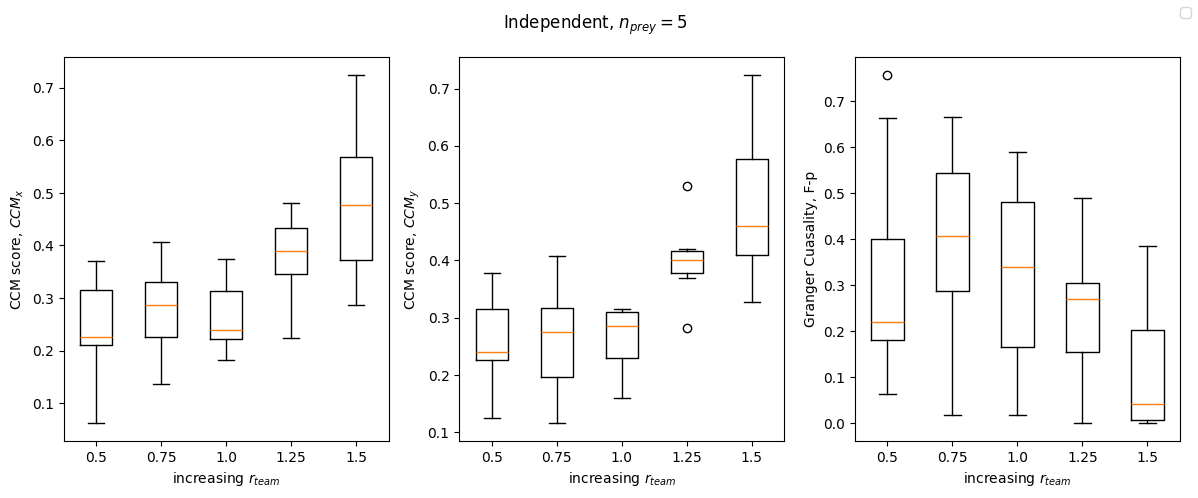

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
# ax.set_xlim(rteam[0], rteam[-1])
# axs[0].set_ylim(0, 1)
# data = pd.DataFrame.from_dict(grouped_data)
labels = [float(r) for r in rteam]
axs[0].boxplot(x = list(grouped_data_ccm_x.values()), labels=labels)
axs[0].set_ylabel('CCM score, $CCM_{x}$')
axs[0].set_xlabel('increasing $r_{team}$')
axs[1].boxplot(x = list(grouped_data_ccm_y.values()), labels=labels)
axs[1].set_ylabel('CCM score, $CCM_{y}$')
axs[1].set_xlabel('increasing $r_{team}$')
axs[2].boxplot(x = list(grouped_data_Fp.values()), labels=labels)
axs[2].set_ylabel('Granger Cuasality, F-p')
axs[2].set_xlabel('increasing $r_{team}$')
# set title 
fig.suptitle(f'Independent, $n_{{prey}}={nprey}$')
fig.legend()
fig.tight_layout()
plt.show()
fig.savefig('shared_causal.png', dpi=300)